# 1. Mục tiêu đồ án


# 2. Tập dữ liệu LaRS



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
shared_dataset_path = '/content/drive/MyDrive/Thực hành UIT/ĐỒ ÁN CE340/LaRS_dataset'

In [5]:
import os
shared_dataset_path = '/content/drive/MyDrive/ĐỒ ÁN CE340/LaRS_dataset'

In [6]:
if os.path.exists(shared_dataset_path):
    files = os.listdir(shared_dataset_path)
    print("Các tệp trong thư mục LaRS_dataset được chia sẻ:")
    for file in files:
        print(file)
else:
    print(f"Không tìm thấy thư mục LaRS_dataset trong 'Shared with me'. Vui lòng kiểm tra lại.")

Các tệp trong thư mục LaRS_dataset được chia sẻ:
lars_v1.0.0_images.zip
lars_v1.0.0_annotations.zip


# 3. Kiến trúc mô hình
// Mô tả kiến trúc mô hình được lựa chọn

// Danh sách mô hình được lựa chọn

## Thiết lập môi trường

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import zipfile

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import fcn_resnet50

## Set seeds

In [2]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

set_seed(seed=2025)

Random seed 2025 has been set.


## Định nghĩa mô hình

Để hiện thực một mô hình có thể triển khai trên hệ thống nhúng Raspberry Pi Zero 2W, tức là một hệ thống với giới hạn dung lượng nhỏ và tốc độ xử lý thấp, mô hình cần được thiết kế với kích thước nhỏ, chi phí tính toán cần được giảm xuống.

> Tham khảo: https://www.geeksforgeeks.org/ml-introduction-to-transfer-learning/

Nhóm đã chọn sử dụng phương pháp **transfer learning** để retrain mô hình.
Phương pháp Transfer Learning là một kỹ thuật học máy nhằm tái đào tạo một mô hình đã được đào tạo trước để thực hiện một nhiệm vụ khác. Hướng tiếp cận này sẽ hiệu quả khi nhiệm vụ thứ hai liên quan đến nhiệm vụ thứ nhất hoặc khi dữ liệu cho nhiệm vụ thứ hai có giới hạn.

Transfer Learning sẽ giải quyết tình trạng hạn chế dữ liệu, giúp nâng cao hiệu suất, thời gian và tối ưu chi phí, đáp ứng khả năng tái sử dụng.

Các bước thực hiện:
- **Pre-trained Model**: Huấn luyện mô hình với dữ liệu lớn cho một tác vụ cụ thể. Mô hình sẽ học tập các đặc trưng và mẫu tổng quát liên quan đến tửng tác vụ.
- **Base Model** - mô hình cơ sở: Mô hình được đào tạo sẽ bao gồm các lớp xử lý dữ liệu để học các biểu diễn phân cấp, nắm bắt các tính năng từ cấp thấp đến phức tạp.
- **Transfer Learning**: Xác định các lớp trong mô hình cơ sở nắm các thông tin tổng quan đáp ứng tác vụ gốc và tác vụ mới. Những lớp này thường nằm ở đầu của mạng.
- **Fine-tuning**: Tinh chỉnh các lớp đã được chọn với dữ liệu cho tác vụ mới. Điều này sẽ giúp cho mô hình vẫn giữ được các tri thức ban đầu trong khi tinh chỉnh các tham số để đáo ứng các yêu cầu của tác vụ mới.

Hai loại lớp của mô hình trong phương pháp transfer learning
- Frozen Layers - Lớp được đóng băng => giữ các đặc trưng ban đầu của mô hình.
- Trainable Layers - Lớp có thể đào tạo => được đào tạo cho tác vụ mới.



## Load mô hình

In [3]:
!apt-get install tree
# !tree -L 2 -d /content/drive/MyDrive/Thực\ hành\ UIT/ĐỒ\ ÁN\ CE340/LaRS_dataset
!tree -L 2 -d '/content/drive/MyDrive/ĐỒ ÁN CE340/LaRS_dataset'

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


Too many parameters - 2


# 4. Tiền xử lý dữ liệu

In [5]:
shared_dataset_path = 'ce340-lars-semantic/LaRS_dataset'

In [ ]:
# Định nghĩa các đường dẫn
# dataset_path = '/content/drive/MyDrive/Thực hành UIT/ĐỒ ÁN CE340/LaRS_dataset'
images_zip_path = os.path.join(shared_dataset_path, 'lars_v1.0.0_images.zip')
annotations_zip_path = os.path.join(shared_dataset_path, 'lars_v1.0.0_annotations.zip')
extracted_images_path = '/content/lars_images'
extracted_annotations_path = '/content/lars_annotations'
image_root_folder = 'images'
mask_root_folder = 'semantic_annotations'
target_size = (320, 320)  # Kích thước ảnh sau khi resize
train_ratio = 0.8
val_ratio = 0.2

# Đảm bảo các thư mục giải nén tồn tại
os.makedirs(extracted_images_path, exist_ok=True)
os.makedirs(extracted_annotations_path, exist_ok=True)

# Đường dẫn đến thư mục ảnh và mask sau khi giải nén
train_images_path = os.path.join(extracted_images_path, 'train', 'images')
val_images_path = os.path.join(extracted_images_path, 'val', 'images')
train_masks_path = os.path.join(extracted_annotations_path, 'train', 'semantic_masks')
val_masks_path = os.path.join(extracted_annotations_path, 'val', 'semantic_masks')

# Giải nén dữ liệu nếu chưa được giải nén
if not os.path.exists(train_images_path) or not os.path.exists(val_images_path):
    print("Đang giải nén ảnh...")
    with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_images_path)
    print("Giải nén ảnh hoàn tất.")

if not os.path.exists(train_masks_path) or not os.path.exists(val_masks_path):
    print("Đang giải nén mask...")
    with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_annotations_path)
    print("Giải nén mask hoàn tất.")

# Lấy danh sách tên ảnh từ thư mục train
train_image_names = [img.split('.')[0] for img in os.listdir(train_images_path) if img.endswith(('.jpg', '.png'))]
train_image_names.sort()

# Lấy danh sách tên ảnh từ thư mục val
val_image_names = [img.split('.')[0] for img in os.listdir(val_images_path) if img.endswith(('.jpg', '.png'))]
val_image_names.sort()

# Gán giá trị cho train_names và va l_names
train_names = train_image_names
val_names = val_image_names

print(f"Số lượng ảnh train: {len(train_image_names)}")
print(f"Số lượng ảnh val: {len(val_image_names)}")

Số lượng ảnh train: 2605
Số lượng ảnh val: 198


## Load data

In [11]:
def load_image_mask(image_id, image_dir, mask_dir, target_size):
  """Loads an image and its corresponding mask.

  Args:
      image_id: The ID of the image and mask.
      image_dir: The directory containing the images.
      mask_dir: The directory containing the masks.
      target_size: The desired size of the image and mask.

  Returns:
      A tuple containing the image and mask as NumPy arrays, or (None, None) if the image or mask is not found.
  """
  image_path = os.path.join(image_dir, f"{image_id}.jpg")
  mask_path = os.path.join(mask_dir, f"{image_id}.png") # Changed to .png for mask

  try:
      image = Image.open(image_path).convert('RGB')
      mask = Image.open(mask_path).convert('L')  # 'L' for grayscale
      # Resize after converting to NumPy array
      image = np.array(image.resize(target_size)) / 255.0
      mask = np.array(mask.resize(target_size, Image.NEAREST))
      return image, mask

  except (FileNotFoundError, OSError) as e:  # Catch potential image reading errors
      print(f"Error loading image or mask for ID: {image_id}. Error: {e}")
      return None, None


Hiển thị một vài ảnh và mask từ tập train sau tiền xử lý:


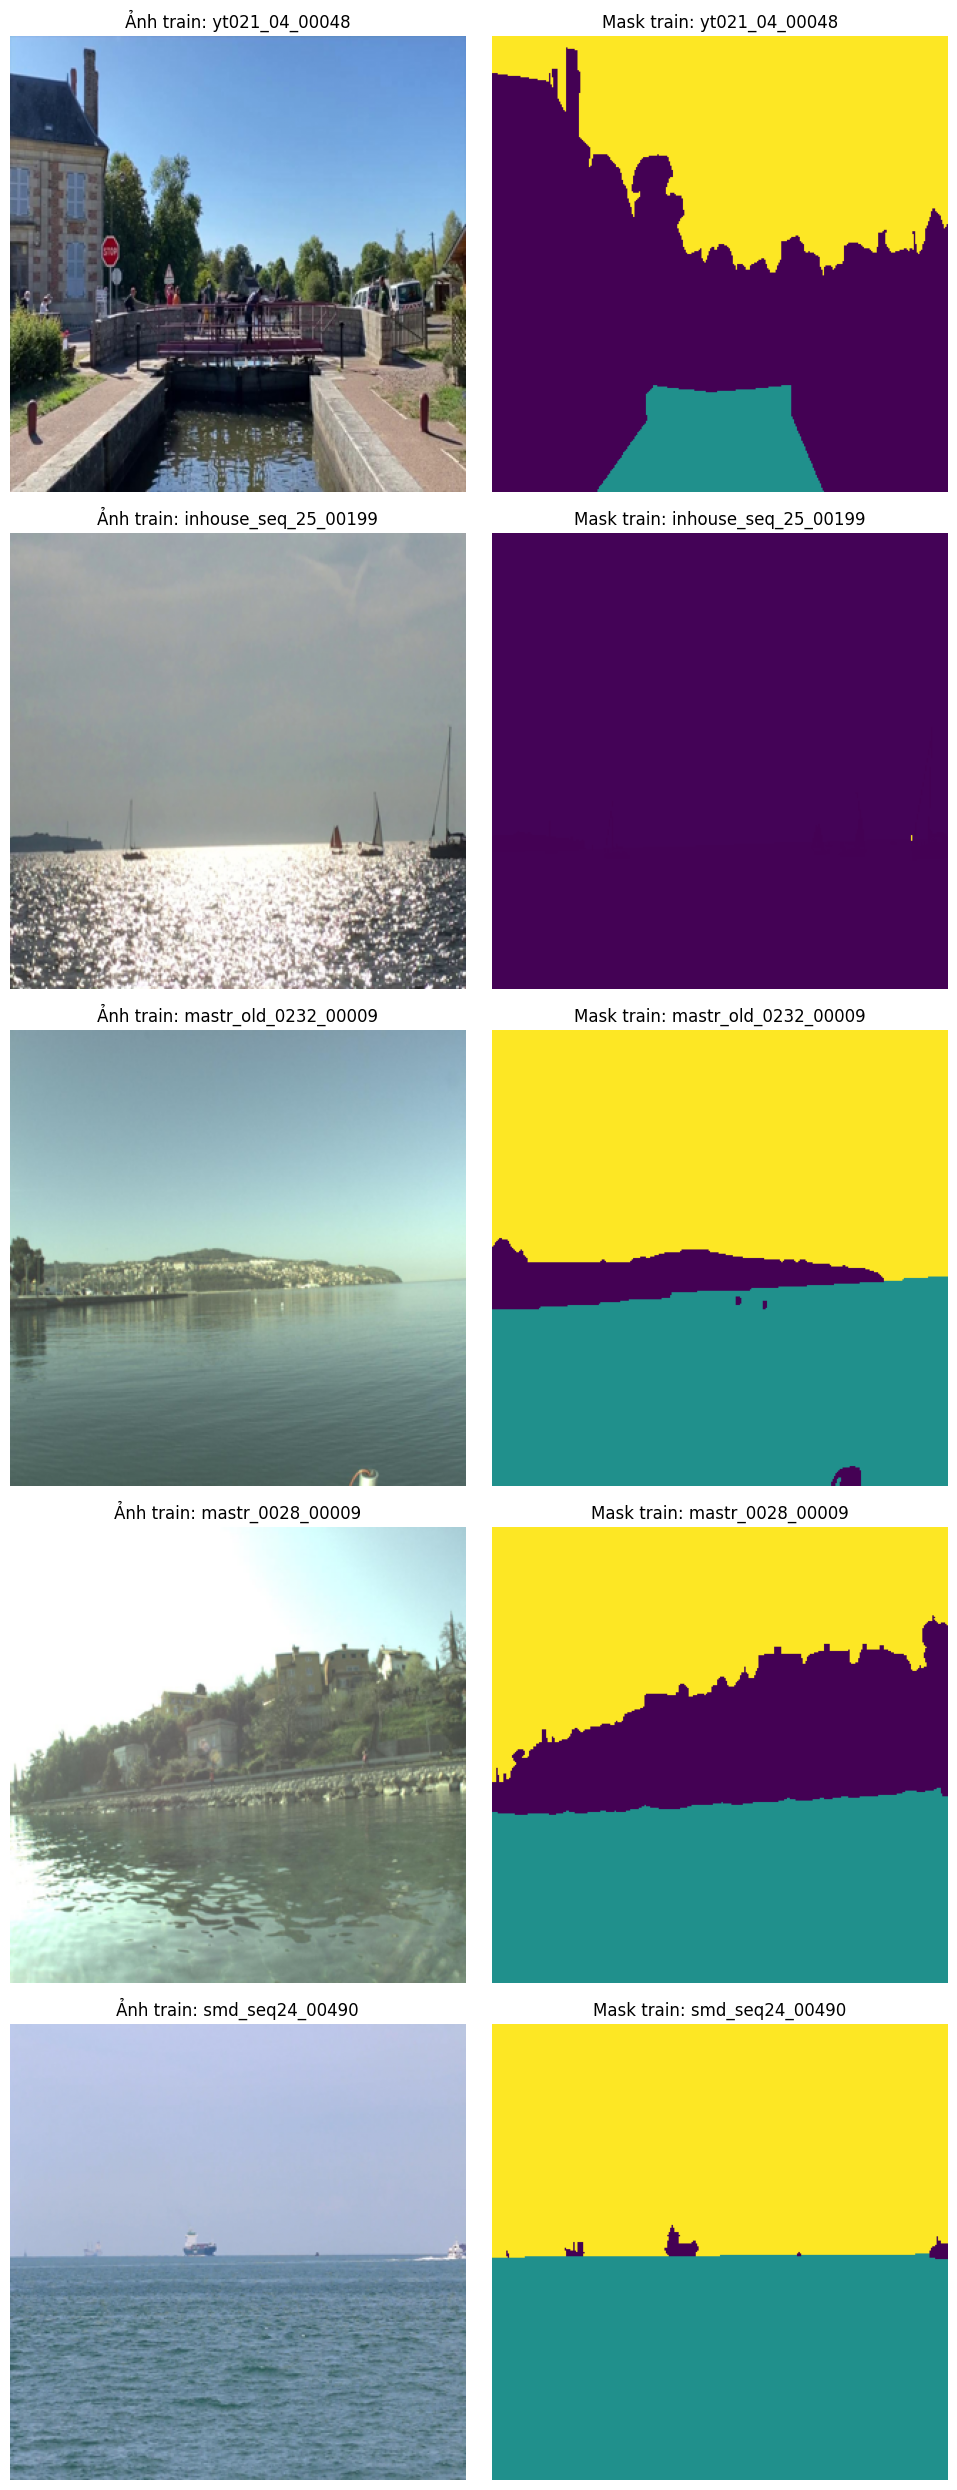

In [12]:
# Hiển thị một số ảnh và mask sau khi tiền xử lý
num_samples_to_show = 5
sample_indices = random.sample(range(len(train_names)), num_samples_to_show)

print("\nHiển thị một vài ảnh và mask từ tập train sau tiền xử lý:")
fig, axes = plt.subplots(num_samples_to_show, 2, figsize=(10, 5 * num_samples_to_show))
for i, idx in enumerate(sample_indices):
    image_id = train_names[idx]
    image, mask = load_image_mask(image_id, train_images_path, train_masks_path, target_size)
    if image is not None and mask is not None:
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Ảnh train: {image_id}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='viridis')
        axes[i, 1].set_title(f"Mask train: {image_id}")
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Tạo Pytorch Dataset
class LaRSDataset(Dataset):
  def __init__(self, image_names, image_dir, mask_dir, target_size):
    self.image_names = image_names
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.target_size = target_size

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    image_id = self.image_names[idx]
    image, mask = load_image_mask(image_id, self.image_dir, self.mask_dir, self.target_size)

    # if self.transform:
    #   resize_transform = transforms.Resize(
    #       (320, 320),
    #       interpolation=transforms.InterpolationMode.BILINEAR)
    #   resize_mask_transform = transforms.Resize(
    #       (320, 320),
    #       interpolation=transforms.InterpolationMode.NEAREST)
    #   image = resize_transform(image)
    #   mask = resize_mask_transform(mask)

    if image is not None and mask is not None:
      image = torch.tensor(image).permute(2, 0, 1).float() # (H, W, C) -> (C, H, W) và chuyển sang float
      mask = torch.tensor(mask).long() # Chuyển mask sang kiểu long cho CrossEntropyLoss
      return image, mask
    else:
      return None, None

In [14]:
# Tạo Pytorch Dataset cho train và val
train_dataset = LaRSDataset(train_names, train_images_path, train_masks_path, target_size)
val_dataset = LaRSDataset(val_names, val_images_path, val_masks_path, target_size)

# Tạo Pytorch DataLoader
batch_size = 32  # Bạn có thể điều chỉnh batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("\nKích thước của train_dataset:", len(train_dataset))
print("Kích thước của val_dataset:", len(val_dataset))
print("Kích thước của train_dataloader:", len(train_dataloader))
print("Kích thước của val_dataloader:", len(val_dataloader))

# In một batch dữ liệu từ train_dataloader để kiểm tra shape
for images, masks in train_dataloader:
    print("\nShape của một batch ảnh train:", images.shape)
    print("Shape của một batch mask train:", masks.shape)
    break


Kích thước của train_dataset: 2605
Kích thước của val_dataset: 198
Kích thước của train_dataloader: 82
Kích thước của val_dataloader: 7

Shape của một batch ảnh train: torch.Size([32, 3, 320, 320])
Shape của một batch mask train: torch.Size([32, 320, 320])


# 5. Các hàm hỗ trợ

In [15]:
num_classes = 4

# model = fcn_resnet50(pretrained=False, num_classes=num_classes).to('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrain=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Hàm train mô hình
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()  # Đặt mô hình ở chế độ huấn luyện
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()  # Xóa gradient cũ
        outputs = model(images)['out']  # Forward
        loss = criterion(outputs, masks)  # Tính loss
        loss.backward()  # Lan truyền ngược
        optimizer.step()  # Cập nhật trọng số

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Loss trung bình mỗi epoch: {avg_loss:.4f}")
    return avg_loss

In [16]:
# Hàm đánh giá mô hình
def val_model(model, dataloader, device, num_classes):
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    total_pixels = 0
    correct_pixels = 0
    iou_scores = []

    with torch.no_grad():  # Không tính gradient
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)  # Chọn class có xác suất cao nhất

            # Tính pixel accuracy
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

            # Tính IoU cho từng class
            for cls in range(num_classes):
                intersection = ((preds == cls) & (masks == cls)).sum().item()
                union = ((preds == cls) | (masks == cls)).sum().item()
                if union > 0:
                    iou_scores.append(intersection / union)

    pixel_accuracy = correct_pixels / total_pixels
    mean_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0.0

    print(f"Độ chính xác theo pixel (Pixel Accuracy): {pixel_accuracy:.4f}")
    print(f"mIoU trung bình: {mean_iou:.4f}")
    return pixel_accuracy, mean_iou

# 6. Huấn luyện mô hình
Vòng lặp huấn luyện

In [ ]:
# Thiết lập số epoch và nơi lưu mô hình
num_epochs = 5
best_miou = 0.0
save_path = '/content/best_segmentation_model.pth'

# Vòng lặp huấn luyện và đánh giá
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Huấn luyện trên tập train
    train_loss = train_model(model, train_dataloader, criterion, optimizer, device)

    # Đánh giá trên tập val
    pixel_acc, miou = val_model(model, val_dataloader, device, num_classes)

    # Lưu mô hình nếu mIoU tốt hơn
    if miou > best_miou:
        best_miou = miou
        torch.save(model.state_dict(), save_path)
        print(f"-> Đã lưu mô hình tốt nhất với mIoU: {best_miou:.4f}")



Epoch 1/5
